In [2]:
import cv2 #opencv
import mediapipe as mp
import math
import csv
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# from mediapipe_estimate import estimate
pd.options.mode.chained_assignment = None 

In [3]:
test_dat=data=pd.read_csv('golfDB_front_orig.csv',index_col='id')
test_dat=test_dat[['youtube_id','events_2','events_5','events_7']]
test_dat['events_5']=test_dat['events_5']-test_dat['events_2']+15
test_dat['events_7']=test_dat['events_7']-test_dat['events_2']+15

test_dat=test_dat.drop(['events_2'],axis=1)
test_dat

,youtube_id,events_5,events_7
id,,,
8,-M5SITXMA2Y,45,53
10,gOBVh7fzyZo,39,47
14,vN3Uc_EhnnY,41,49
19,iW323nsTGtU,49,57
21,xD6KDqPF9cc,39,45
...,...,...,...
1370,g90r9cs1tTw,37,43
1372,eNlBbMI-MhQ,49,59
1374,6K1FD0sOwoI,54,63


In [4]:


def find_mean_index(df,axis='x',minimum=True):
    # Step 1: Identify the Minimum Index for Each Variable
    if minimum:

        if axis=='x':
            min_indices = {
                'halfway_back_wrist_r': df['right_wrist_x'].idxmin(),
                'halfway_back_wrist_l': df['left_wrist_x'].idxmin(),
                # 'halfway_back_elbow_r': df['right_elbow_x'].idxmin(),
                # 'halfway_back_elbow_l': df['left_elbow_x'].idxmin()
            }
        elif axis=='y':
            min_indices = {
                'halfway_back_wrist_r': df['right_wrist_y'].idxmin(),
                'halfway_back_wrist_l': df['left_wrist_y'].idxmin(),
                # 'halfway_back_elbow_r': df['right_elbow_y'].idxmin(),
                # 'halfway_back_elbow_l': df['left_elbow_y'].idxmin()
            }
    else:
        if axis=='x':
            min_indices = {
                'halfway_back_wrist_r': df['right_wrist_x'].idxmax(),
                'halfway_back_wrist_l': df['left_wrist_x'].idxmax(),
                # 'halfway_back_elbow_r': df['right_elbow_x'].idxmax(),
                # 'halfway_back_elbow_l': df['left_elbow_x'].idxmax()
            }
        elif axis=='y':
            min_indices = {
            'halfway_back_wrist_r': df['right_wrist_y'].idxmax(),
            'halfway_back_wrist_l': df['left_wrist_y'].idxmax(),
            # 'halfway_back_elbow_r': df['right_elbow_y'].idxmax(),
            # 'halfway_back_elbow_l': df['left_elbow_y'].idxmax()
        }



    indices = list(min_indices.values())
    # Step 2: Calculate the Mean of These Indices
    mean_index = np.mean(indices)

    # Step 3: Handle Significant Deviations
    threshold = 3  # Define the threshold for significant deviation
    deviations = [abs(index - mean_index) for index in indices]
    
    # Exclude significantly deviated indices
    filtered_indices = [index for index, dev in zip(indices, deviations) if dev < threshold]

    if len(filtered_indices) == 0 and minimum and axis=='x':
        # If all indices are filtered out, handle this case separately
        return df['left_wrist_x'].idxmin() # seems to be working for this dataset
    elif len(filtered_indices) == 0 and not minimum and axis=='x':
        return df['left_wrist_x'].idxmax() 
    elif len(filtered_indices) == 1  and minimum and axis=='x':
        return df['left_wrist_x'].idxmin()
    elif len(filtered_indices) == 1  and not minimum and axis=='x':
        return df['left_wrist_x'].idxmax() 
    if len(filtered_indices) == 0 and minimum and axis=='y':
        # If all indices are filtered out, handle this case separately
        return df['left_wrist_y'].idxmin() # seems to be working for this dataset
    elif len(filtered_indices) == 0 and not minimum and axis=='y':
        return df['left_wrist_y'].idxmax() 
    elif len(filtered_indices) == 1  and minimum and axis=='y':
        return df['left_wrist_y'].idxmin()
    elif len(filtered_indices) == 1  and not minimum and axis=='y':
        return df['left_wrist_y'].idxmax() 
    
    elif len(filtered_indices) == 2:
        # If two indices are not deviated significantly, take their mean
        final_index = round(np.mean(filtered_indices))
    else:
        # If more than two indices are close, recalculate mean with the filtered indices
        final_index = round(np.mean(filtered_indices))

    return final_index


In [5]:
name_list=list('output_video_'+pd.unique(test_dat.youtube_id))
all=len(name_list)
correct_contact=0
correct_top=0
correct_address=0
for fl in name_list:
    try:
        data=pd.read_csv('results_wrist_elbow/variables_'+fl+'.csv')

        #consider only time between backswing and finish
        halfway_back_ind= find_mean_index(data)
        
        halfway_front_ind=find_mean_index(data[data.index>halfway_back_ind],minimum=False)

        middle_data=data[(data.index>halfway_back_ind)&(data.index<halfway_front_ind)]

        #find moment of ball contact as the lowest wrist point on y
        contact_frame=find_mean_index(middle_data,'y',minimum=False)
        # middle_data[middle_data['right_wrist_y']==middle_data['right_wrist_y'].max()].index
        
        #isolate only backswing data
        back_data=data[(data.index<contact_frame)]

        #find moment of top of backswing as the highest wrist point on y
        top_backswing_frame=find_mean_index(back_data,'y')

        # #find moment before start of the swing as the lowest wrist point on y before going halfway back
        # halfway_back_data=data[data['right_wrist_x'].index<halfway_back_ind]
        # # Calculate the absolute differences between successive points
        # halfway_back_data.right_wrist_x = halfway_back_data.right_wrist_x.rolling(window=5).mean()
        # wrist_grad = np.gradient(halfway_back_data.right_wrist_x, halfway_back_data.index)

        # # Finding the point where the wrist x value starts to decrease
        # # We look for the first point where the derivative is consistently negative
        # address_frame = next(i for i, v in enumerate(wrist_grad[5:]) if v < 0) + 5

        
        #extract the gt from golfDB
        yt_id='_'.join(fl.split('_')[2::])
        gt_contact=test_dat[test_dat.youtube_id==yt_id].events_7.item()
        gt_top=test_dat[test_dat.youtube_id==yt_id].events_5.item()
        # gt_address=15

        #calculte tolerance as per golfDB paper (fps=30)
        tolerance_hit=2*(gt_contact//30)
        tolerance_top=2*(gt_top//30)
        # tolerance_address=1



        if gt_contact-tolerance_hit<=contact_frame<=tolerance_hit+gt_contact:
            correct_contact+=1
            print('correct hit esitmate',correct_contact,' estimated [s]:',data[data.index==contact_frame].timestamp.item(),'gt [s]:', data[data.index==gt_contact].timestamp.item(),', tolerance [frames]:',tolerance_hit, ', frame difference:', abs(contact_frame-gt_contact))
        else:
            print('incorrect hit estimate',correct_contact,' estimated [s]:',data[data.index==contact_frame].timestamp.item(),', gt [s]:', data[data.index==gt_contact].timestamp.item(),', tolerance [frames]:',tolerance_hit,', frame difference:', abs(contact_frame-gt_contact))

        if gt_top-tolerance_top<=top_backswing_frame<=tolerance_top+gt_top:
            correct_top+=1
            print('correct top esitmate',correct_top,' estimated [s]:',data[data.index==top_backswing_frame].timestamp.item(),'gt [s]:', data[data.index==gt_top].timestamp.item(),', tolerance [frames]:',tolerance_top, ', frame difference:', abs(top_backswing_frame-gt_contact))
        else:
            print('icorrect top esitmate',correct_top,' estimated [s]:',data[data.index==top_backswing_frame].timestamp.item(),'gt [s]:', data[data.index==gt_top].timestamp.item(),', tolerance [frames]:',tolerance_top, ', frame difference:', abs(top_backswing_frame-gt_contact))
        # if gt_address-tolerance_address<=address_frame<=tolerance_address+gt_address:
        #     correct_address+=1
        #     print('correct address esitmate',correct_address,' estimated [s]:',data[data.index==address_frame].timestamp.item(),'gt [s]:', data[data.index==gt_address].timestamp.item(),', tolerance [frames]:',tolerance_address, ', frame difference:', abs(address_frame-gt_address))
        # else:
        #     print(fl,'icorrect address esitmate',correct_address,' estimated [s]:',data[data.index==address_frame].timestamp.item(),'gt [s]:', data[data.index==gt_address].timestamp.item(),', tolerance [frames]:',tolerance_address, ', frame difference:', abs(address_frame-gt_address))
        print('----------------------------------------------------------------------------------------------------')
    except Exception as e:
        print(e,fl)
        print('----------------------------------------------------------------------------------------------------')
        all=all-1
        
              
            
accuracy_contact=correct_contact/all
accuracy_top=correct_top/all
# accuracy_address=correct_address/all

print(f'contatct estimation accuracy: {accuracy_contact}, top estimation accuracy: {accuracy_top}')

correct hit esitmate 1  estimated [s]: 1.7 gt [s]: 1.77 , tolerance [frames]: 2 , frame difference: 2
icorrect top esitmate 0  estimated [s]: 1.4 gt [s]: 1.5 , tolerance [frames]: 2 , frame difference: 11
----------------------------------------------------------------------------------------------------
correct hit esitmate 2  estimated [s]: 1.53 gt [s]: 1.57 , tolerance [frames]: 2 , frame difference: 1
correct top esitmate 1  estimated [s]: 1.27 gt [s]: 1.3 , tolerance [frames]: 2 , frame difference: 9
----------------------------------------------------------------------------------------------------
attempt to get argmin of an empty sequence output_video_vN3Uc_EhnnY
----------------------------------------------------------------------------------------------------
correct hit esitmate 3  estimated [s]: 1.87 gt [s]: 1.9 , tolerance [frames]: 2 , frame difference: 1
icorrect top esitmate 1  estimated [s]: 1.4 gt [s]: 1.63 , tolerance [frames]: 2 , frame difference: 15
-------------

In [6]:
# data=pd.read_csv('results/variables_'+fl+'.csv')
# halfway_back_ind=data['right_wrist_x'].idxmin()
# data_back=data[data.index>halfway_back_ind]
# data['sum_wrists_hit']=data['right_wrist_y']+data.timestamp
# ev_6=data[data['sum_wrists_hit']==data['sum_wrists_hit'].max()].index

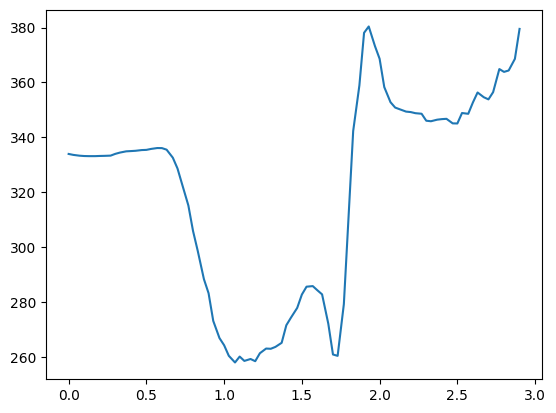

In [10]:
plt.plot(data.timestamp,data.left_wrist_x,label='x')